# New Data Analysis

## Import Lib

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Get All Data

In [2]:
def get_all_data():
    files_name = '_BMS_influxdb_data.csv'
    files_path = []
    for root, dirs, files in os.walk('../data/'):
        for file in files:
            if file.endswith(files_name):
                files_path.append(os.path.join(root, file))

    data = [pd.read_csv(file, index_col=[0]) for file in files_path]
    df = pd.concat(data, ignore_index=True)
    df.sort_values('timestamp', inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.reset_index(drop=True, inplace=True)

    return df

In [3]:
all_data = get_all_data()
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33239030 entries, 0 to 33239029
Data columns (total 35 columns):
 #   Column                       Dtype              
---  ------                       -----              
 0   timestamp                    datetime64[ns, UTC]
 1   System voltage               int64              
 2   System Current               int64              
 3   SOC                          int64              
 4   SOH                          int64              
 5   Battery Subsystem Voltage.1  int64              
 6   Battery Subsystem Current.1  int64              
 7   SOC.1                        int64              
 8   SOH.1                        int64              
 9   Sum of cell voltage.1        int64              
 10  Battery Subsystem Voltage.2  int64              
 11  Battery Subsystem Current.2  int64              
 12  SOC.2                        int64              
 13  SOH.2                        int64              
 14  Sum of cell volt

all_data.to_csv('../data/all_dataset.csv')

## Data Preprocessing

In [4]:
def drop_data(df):
    df = df[df['System voltage'] != 0]
    return df

In [5]:
all_data = drop_data(all_data)

In [6]:
def calculate_sum_to_hourly(data, column):
    return data[column].resample('60min').apply(lambda x: x.sum() * (1/3600))


def resample_with_change_rate(df):
    df = df[df['System voltage'] != 0]

    df['Power'] = df['System voltage'] * df['System Current'] 

    df['Voltage_change'] = df['System voltage'].diff()
    df['Current_change'] = df['System Current'].diff()
    df['Power_change'] = df['Power'].diff()
    df['SOC_change'] = df['SOC'].diff()

    df.set_index('timestamp', inplace=True)
    df_resampled = df.resample('60min').mean()
    
    df_resampled['Coulomb_Counting'] = calculate_sum_to_hourly(df, 'System Current')
    df_resampled['Energy'] = calculate_sum_to_hourly(df, 'Power')
    
    df_resampled['SOH'] = df['SOH'].resample('60min').last()
    df_resampled = df_resampled.fillna(0)
    df_resampled.reset_index(inplace=True)
    
    return df_resampled[df_resampled['SOH'] > 0]

In [7]:
main_system = all_data[['timestamp', 'SOH', 'System voltage', 'System Current', 'SOC']]
train_subsystem = all_data[['timestamp', 'SOH.1', 'Battery Subsystem Voltage.1', 'Battery Subsystem Current.1', 'SOC.1']]
val_subsystem = all_data[['timestamp', 'SOH.2', 'Battery Subsystem Voltage.2', 'Battery Subsystem Current.2', 'SOC.2']]

In [9]:
main_system_resampled = resample_with_change_rate(main_system)
subsystem_1_resampled = resample_with_change_rate(train_subsystem.rename(columns={
    'SOH.1': 'SOH',
    'Battery Subsystem Voltage.1': 'System voltage',
    'Battery Subsystem Current.1': 'System Current',
    'SOC.1': 'SOC'
}))
subsystem_2_resampled = resample_with_change_rate(val_subsystem.rename(columns={
    'SOH.2': 'SOH',
    'Battery Subsystem Voltage.2': 'System voltage',
    'Battery Subsystem Current.2': 'System Current',
    'SOC.2': 'SOC',
}))

/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

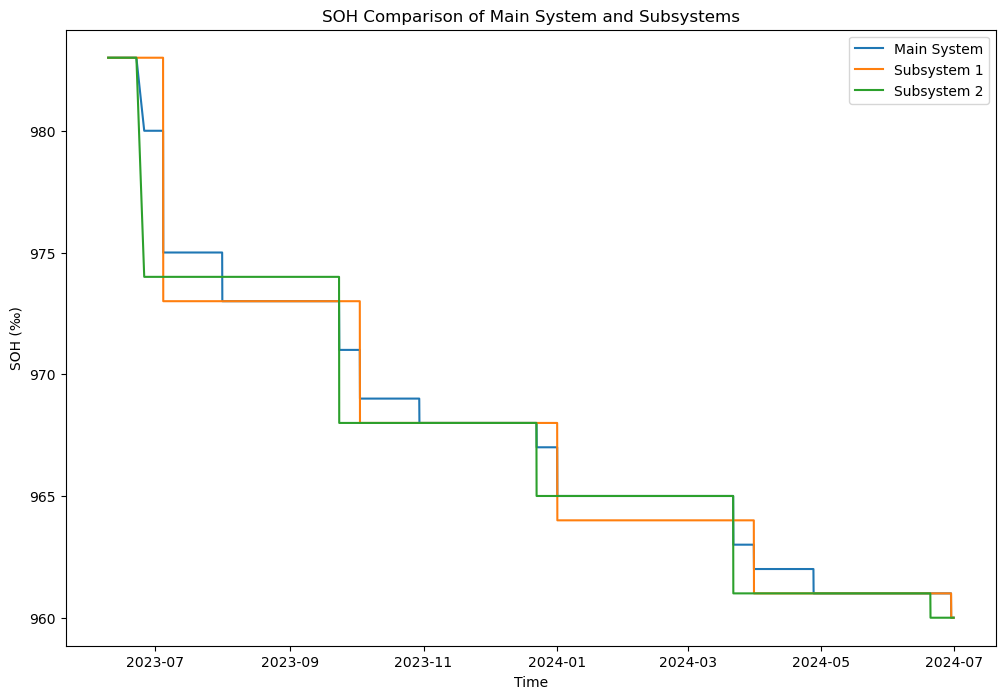

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

sns.lineplot(x='timestamp', y='SOH', data=main_system_resampled, label='Main System')
sns.lineplot(x='timestamp', y='SOH', data=subsystem_1_resampled, label='Subsystem 1')
sns.lineplot(x='timestamp', y='SOH', data=subsystem_2_resampled, label='Subsystem 2')

plt.title('SOH Comparison of Main System and Subsystems')
plt.ylabel('SOH (‰)')
plt.xlabel('Time')
plt.legend()
plt.show()


### Scaler

In [12]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

main_system_resampled.set_index('timestamp', inplace=True)
test_scaled = scaler.fit_transform(main_system_resampled)

subsystem_1_resampled.set_index('timestamp', inplace=True)
train_scaled = scaler.fit_transform(subsystem_1_resampled)

subsystem_2_resampled.set_index('timestamp', inplace=True)
val_scaled = scaler.fit_transform(subsystem_2_resampled)

In [13]:
print(f'test size:{test_scaled.shape}')
print(f'train size:{train_scaled.shape}')
print(f'val size:{val_scaled.shape}')

test size:(9086, 11)
train size:(9086, 11)
val size:(9086, 11)


In [14]:
import torch

def create_dataset(dataset, n):
    X, y = [], []
    for i in range(n, len(dataset)):
        X.append(dataset[i - n:i, 1:dataset.shape[1]])
        y.append(dataset[i, 0])
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [15]:
trainX, trainY=create_dataset(train_scaled, 168)
valX, valY = create_dataset(val_scaled, 168)

print(trainX.shape)
print(trainY.shape)

torch.Size([8918, 168, 10])
torch.Size([8918])


/tmp/ipykernel_584071/2911067003.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [24]:
import torch.utils.data as data
loader = data.DataLoader(data.TensorDataset(trainX, trainY), shuffle=True, batch_size = 2048)

## Train Model

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [55]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=10, hidden_size=64, num_layers=3, batch_first=True)
        self.linear = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.linear(out[:, -1, :])
        return out

In [79]:
import torch.optim as optim

trainX_tensor = torch.tensor(trainX, dtype=torch.float32)
trainY_tensor = torch.tensor(trainY, dtype=torch.float32).unsqueeze(1) 

valX_tensor = torch.tensor(valX, dtype=torch.float32)
valY_tensor = torch.tensor(valY, dtype=torch.float32).unsqueeze(1) 

learning_rate = 0.0005
num_epochs = 920

model = GRUModel().to(device)

criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

trainX_tensor = trainX_tensor.to(device)
trainY_tensor = trainY_tensor.to(device)

valX_tensor = valX_tensor.to(device)
valY_tensor = valY_tensor.to(device)


/tmp/ipykernel_584071/41365109.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX_tensor = torch.tensor(trainX, dtype=torch.float32)
/tmp/ipykernel_584071/41365109.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainY_tensor = torch.tensor(trainY, dtype=torch.float32).unsqueeze(1)
/tmp/ipykernel_584071/41365109.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valX_tensor = torch.tensor(valX, dtype=torch.float32)
/tmp/ipykernel_584071/41365109.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sour

In [80]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(trainX_tensor)
    train_loss = criterion(outputs, trainY_tensor)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    model.eval()  
    with torch.no_grad():
        val_outputs = model(valX_tensor)
        val_loss = criterion(val_outputs, valY_tensor)
        val_losses.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [10/920], Train Loss: 0.7981, Val Loss: 0.8163
Epoch [20/920], Train Loss: 0.6166, Val Loss: 0.7721
Epoch [30/920], Train Loss: 0.5489, Val Loss: 0.8828
Epoch [40/920], Train Loss: 0.4945, Val Loss: 0.7769
Epoch [50/920], Train Loss: 0.4496, Val Loss: 0.7976
Epoch [60/920], Train Loss: 0.3968, Val Loss: 0.6781
Epoch [70/920], Train Loss: 0.3352, Val Loss: 0.5539
Epoch [80/920], Train Loss: 0.2824, Val Loss: 0.4397
Epoch [90/920], Train Loss: 0.2364, Val Loss: 0.3347
Epoch [100/920], Train Loss: 0.2024, Val Loss: 0.2667
Epoch [110/920], Train Loss: 0.1743, Val Loss: 0.2442
Epoch [120/920], Train Loss: 0.1838, Val Loss: 0.2557
Epoch [130/920], Train Loss: 0.1539, Val Loss: 0.2452
Epoch [140/920], Train Loss: 0.1440, Val Loss: 0.2435
Epoch [150/920], Train Loss: 0.1325, Val Loss: 0.2467
Epoch [160/920], Train Loss: 0.1221, Val Loss: 0.2508
Epoch [170/920], Train Loss: 0.1098, Val Loss: 0.2618
Epoch [180/920], Train Loss: 0.0996, Val Loss: 0.2816
Epoch [190/920], Train Loss: 0.0918, 

## Eval

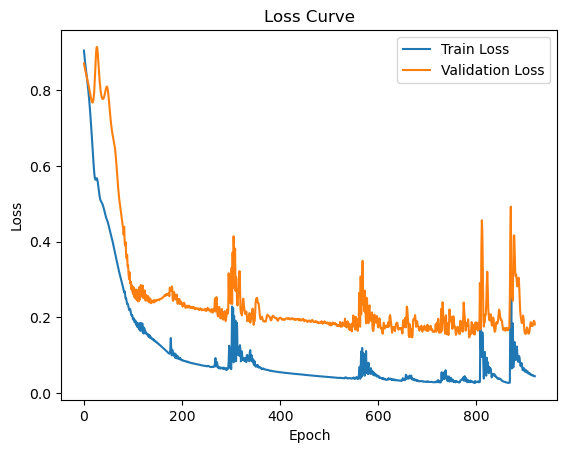

In [81]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
testX, testY = create_dataset(test_scaled, 168)

In [83]:
# 將測試集轉換為 PyTorch 張量
testX_tensor = torch.tensor(testX, dtype=torch.float32).to(device)
testY_tensor = torch.tensor(testY, dtype=torch.float32).unsqueeze(1).to(device)  # [batch_size, 1]


/tmp/ipykernel_584071/2904167436.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testX_tensor = torch.tensor(testX, dtype=torch.float32).to(device)
/tmp/ipykernel_584071/2904167436.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testY_tensor = torch.tensor(testY, dtype=torch.float32).unsqueeze(1).to(device)  # [batch_size, 1]


In [84]:
model.eval()
with torch.no_grad():
    test_predictions = model(testX_tensor)


Mean Squared Error: 0.0809


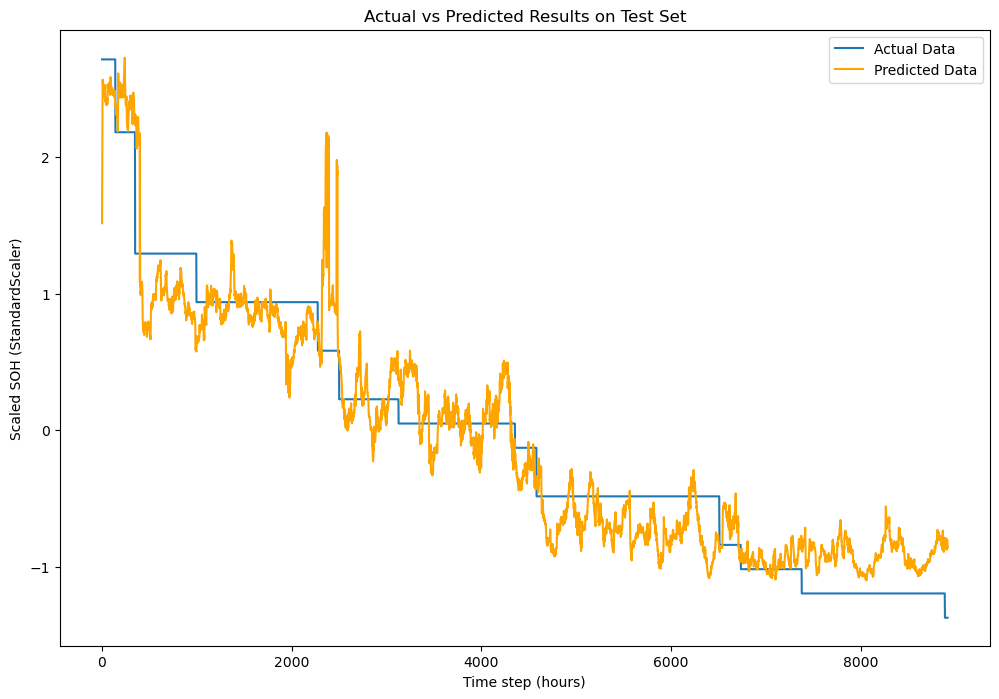

In [85]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

mse_loss = F.mse_loss(test_predictions, testY_tensor)
print(f'Mean Squared Error: {mse_loss.item():.4f}')

predicted_outputs = test_predictions.cpu().numpy()
testY_actual = testY_tensor.cpu().numpy()


plt.figure(figsize=(12, 8))
plt.plot(testY_actual, label='Actual Data')
plt.plot(predicted_outputs, label='Predicted Data', color = 'orange')

plt.title('Actual vs Predicted Results on Test Set')
plt.xlabel('Time step (hours)')
plt.ylabel('Scaled SOH (StandardScaler)')
plt.legend()

# 顯示圖像
plt.show()

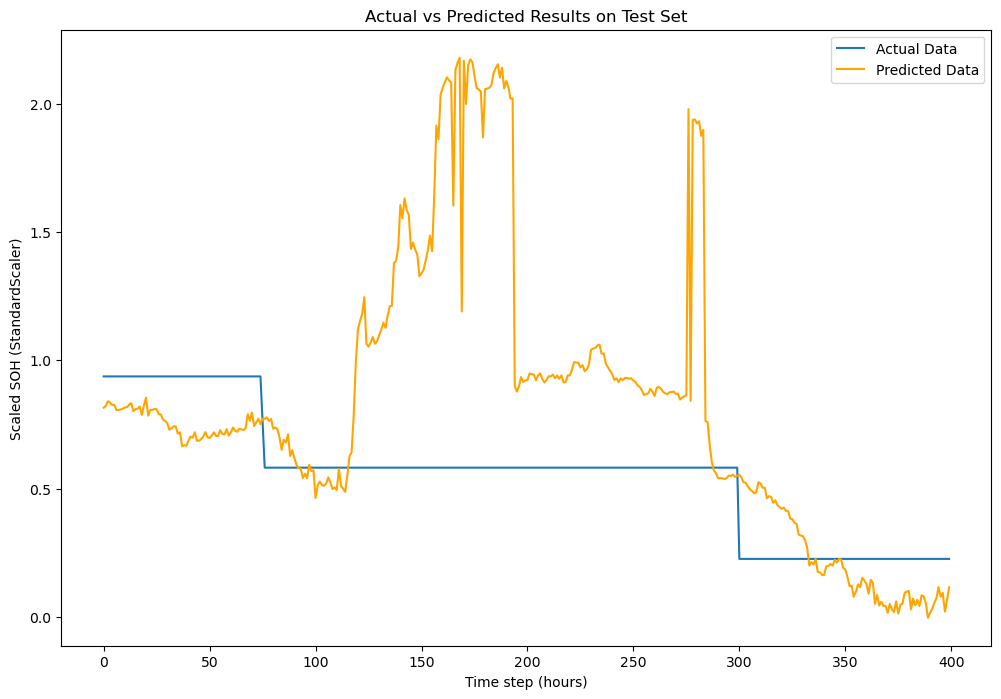

In [91]:
plt.figure(figsize=(12, 8))
plt.plot(testY_actual[2200:2600], label='Actual Data')
plt.plot(predicted_outputs[2200:2600], label='Predicted Data', color = 'orange')

plt.title('Actual vs Predicted Results on Test Set')
plt.xlabel('Time step (hours)')
plt.ylabel('Scaled SOH (StandardScaler)')
plt.legend()

# 顯示圖像
plt.show()

In [86]:
torch.save(model, '../models/soh_gru64x3_1h_0809.pt')